# Midterm Project

> Develop classification models to predict a target variable.
> Evaluate the classification models based on the different performance metrics.

[Link to Dataset](https://www.kaggle.com/datasets/adeniranstephen/obesity-prediction-dataset)

In [1]:
# Import dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

raw = pd.read_csv('data/obesity_dataset.csv')

raw = raw.sample(frac=1).reset_index(drop=True)

raw

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,25,1.63,46.06,yes,yes,2.69,3.04,Frequently,no,2.21,no,1.62,0.000,no,Public_Transportation,Insufficient_Weight
1,Female,26,1.61,104.94,yes,yes,3.00,3.00,Sometimes,no,1.32,no,0.00,0.540,Sometimes,Public_Transportation,Obesity_Type_III
2,Male,23,1.71,82.01,yes,yes,2.78,2.12,Sometimes,no,2.98,no,2.16,0.204,Sometimes,Public_Transportation,Overweight_Level_II
3,Female,33,1.55,55.00,yes,yes,3.00,1.00,Sometimes,no,3.00,no,2.00,1.000,Sometimes,Public_Transportation,Normal_Weight
4,Male,18,1.76,85.05,yes,yes,2.85,3.00,Sometimes,no,2.88,no,1.00,0.429,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Male,18,1.71,50.93,yes,yes,2.00,3.00,Sometimes,no,2.00,no,0.00,1.594,Sometimes,Public_Transportation,Insufficient_Weight
2107,Female,19,1.57,41.93,no,yes,2.07,1.00,Sometimes,no,1.68,no,0.00,1.719,Sometimes,Public_Transportation,Insufficient_Weight
2108,Female,21,1.69,122.81,yes,yes,3.00,3.00,Sometimes,no,1.41,no,0.93,0.840,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,31,1.68,63.00,yes,yes,3.00,1.00,Frequently,no,2.00,no,1.00,1.000,Sometimes,Automobile,Normal_Weight


### Data Cleaning

1. CALC, CAEC Column must only have the values [Never, Sometimes, Frequently, Always]
2. Standardize CAEC, CALC to numeric values
3. Change underscores to whitespace
4. Simplify Gender to M and F
5. Change yes/no fields to binary 1/0
6. Rearrange Columns
7. Set aside 10% of the data

In [2]:
# Cleanup CALC and CAEC [Transform no to Never] - John Mihael
raw['CALC'] = raw['CALC'].replace("no", "Never")
raw['CAEC'] = raw['CAEC'].replace("no", "Never")

# Cleanup CALC and CAEC [0-3 scale] - Shaun
mapping = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}

raw['CAEC'] = raw['CAEC'].map(mapping)
raw['CALC'] = raw['CALC'].map(mapping)

# Change underscore values to whitespace and standardized - Cazindra
# Replace underscores in COLUMN NAMES (if they exist)
raw.columns = raw.columns.str.replace('_', ' ')

# Apply title case ONLY to column names containing spaces (multi-word columns)
raw.columns = [
    col.title() if ' ' in col else col  # Title case only if space exists
    for col in raw.columns
]

# Replace underscores in DATA ROWS for specific columns
for col in ['MTRANS', 'NObeyesdad']:
    raw[col] = raw[col].astype(str).str.replace('_', ' ', regex=True)

# Columns to standardize to title case
title_case_columns = [
    'Family History With Overweight',  # After underscore replacement
    'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC'
]

# Convert values in these columns to title case
raw[title_case_columns] = raw[title_case_columns].apply(lambda x: x.astype(str).str.title())

# Simplified Gender to M or F
raw['Gender'] = raw['Gender'].replace({'Female': 'F', 'Male': 'M'})

# Transform No/Yes to 0/1 - Joyce
columns_with_yes_no = ['Family History With Overweight', 'FAVC', 'SMOKE', 'SCC']
raw[columns_with_yes_no] = raw[columns_with_yes_no].replace({'Yes': 1, 'No': 0})

# Rearrange columns - Jude (Autofill)
raw = raw[[
    # Yes/No columns
    'Gender', 'Age', 'Height', 'Weight', 'Family History With Overweight', 'FAVC', 'SMOKE', 'SCC',
    # Decimal (numeric) columns
    'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
    # Target column (must remain last)
    'NObeyesdad'
]]

# Change M - 0 and F - 1
raw['Gender'] = raw['Gender'].replace({'M': 0, 'F': 1})

# Get unseen dataset
ctgnb_unseen = raw.iloc[1900:2110].reset_index(drop=True) # Get unseen sample
ctgnb_data = raw.iloc[0:1899].reset_index(drop=True) # Cut original dataset

ctgnb_data

C:\Users\INSTRUCT-D522lab\AppData\Local\Temp\ipykernel_11632\1178970283.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['Gender'] = raw['Gender'].replace({'M': 0, 'F': 1})


,Gender,Age,Height,Weight,Family History With Overweight,FAVC,SMOKE,SCC,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad
0,1,25,1.63,46.06,1,1,0,0,2.69,3.04,2.21,1.62,0.000,Insufficient Weight
1,1,26,1.61,104.94,1,1,0,0,3.00,3.00,1.32,0.00,0.540,Obesity Type III
2,0,23,1.71,82.01,1,1,0,0,2.78,2.12,2.98,2.16,0.204,Overweight Level II
3,1,33,1.55,55.00,1,1,0,0,3.00,1.00,3.00,2.00,1.000,Normal Weight
4,0,18,1.76,85.05,1,1,0,0,2.85,3.00,2.88,1.00,0.429,Overweight Level II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894,1,19,1.63,82.00,1,1,0,0,1.08,2.87,1.12,0.00,1.617,Obesity Type I
1895,0,26,1.85,105.00,1,1,0,0,3.00,3.00,3.00,2.00,2.000,Obesity Type I
1896,0,29,1.64,89.42,1,1,0,0,1.33,3.00,1.88,0.32,0.000,Obesity Type I
1897,1,19,1.76,80.00,1,1,0,0,2.00,1.41,2.65,2.88,0.954,Overweight Level I


### Prepare Data

1. Split features and target column
2. Prepare training and testing data.

In [3]:
# Split Features and Target Column
features = ctgnb_data.drop('NObeyesdad', axis=1)
target_col = ctgnb_data['NObeyesdad']

features_train, features_test, target_train, target_test = train_test_split(
    features, target_col, test_size=0.2
)

### Perform Multinomial Training

Confusion Matrix: [[40 10  1  0  2  0  0]
 [ 9 22  2  0  1  8  2]
 [ 0  1 52  6  0  1  9]
 [ 0  0  1 51  0  1  1]
 [ 0  0  0  0 64  0  0]
 [ 3  7  4  0  1 34  7]
 [ 0  7 11  2  0  5 15]]


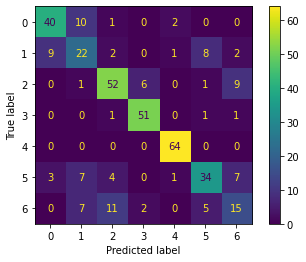

                     precision    recall  f1-score   support

Insufficient Weight       0.77      0.75      0.76        53
      Normal Weight       0.47      0.50      0.48        44
     Obesity Type I       0.73      0.75      0.74        69
    Obesity Type II       0.86      0.94      0.90        54
   Obesity Type III       0.94      1.00      0.97        64
 Overweight Level I       0.69      0.61      0.65        56
Overweight Level II       0.44      0.38      0.41        40

           accuracy                           0.73       380
          macro avg       0.70      0.70      0.70       380
       weighted avg       0.72      0.73      0.73       380



In [4]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
# Import Naive Bayes model
model = CategoricalNB()

model.fit(features_train, target_train)

y_pred = model.predict(features_test)

print("Confusion Matrix:", confusion_matrix(target_test, y_pred))

cm = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(target_test, y_pred))
cm.plot()
plt.show()
print(classification_report(target_test, y_pred))

### Use the model

In [5]:
ctgnb_unseen.drop('NObeyesdad', axis=1, inplace=True)
results = model.predict(ctgnb_unseen)

ctgnb_unseen['Predictions'] = results

ctgnb_unseen

,Gender,Age,Height,Weight,Family History With Overweight,FAVC,SMOKE,SCC,FCVC,NCP,CH2O,FAF,TUE,Predictions
0,1,19,1.52,42.00,0,1,0,0,2.91,1.06,1.60,0.11,0.773,Insufficient Weight
1,0,19,1.70,79.68,1,0,0,0,2.74,2.16,1.09,0.11,0.004,Overweight Level II
2,0,18,1.84,60.00,1,1,0,0,3.00,4.00,2.00,2.00,0.000,Normal Weight
3,0,26,1.77,114.25,1,1,0,0,2.18,3.00,2.13,1.31,0.079,Obesity Type II
4,1,22,1.70,66.00,1,0,0,1,3.00,3.00,2.00,2.00,1.000,Normal Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1,18,1.59,53.00,0,0,0,0,1.00,3.00,1.00,1.00,2.000,Insufficient Weight
206,0,18,1.71,50.93,1,1,0,0,2.00,3.00,2.00,0.00,1.594,Insufficient Weight
207,1,19,1.57,41.93,0,1,0,0,2.07,1.00,1.68,0.00,1.719,Insufficient Weight
208,1,21,1.69,122.81,1,1,0,0,3.00,3.00,1.41,0.93,0.840,Obesity Type III


In [7]:
# Original
raw.iloc[1900:2110].reset_index(drop=True) 

,Gender,Age,Height,Weight,Family History With Overweight,FAVC,SMOKE,SCC,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad
0,1,19,1.52,42.00,0,1,0,0,2.91,1.06,1.60,0.11,0.773,Insufficient Weight
1,0,19,1.70,79.68,1,0,0,0,2.74,2.16,1.09,0.11,0.004,Overweight Level II
2,0,18,1.84,60.00,1,1,0,0,3.00,4.00,2.00,2.00,0.000,Insufficient Weight
3,0,26,1.77,114.25,1,1,0,0,2.18,3.00,2.13,1.31,0.079,Obesity Type II
4,1,22,1.70,66.00,1,0,0,1,3.00,3.00,2.00,2.00,1.000,Normal Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1,18,1.59,53.00,0,0,0,0,1.00,3.00,1.00,1.00,2.000,Normal Weight
206,0,18,1.71,50.93,1,1,0,0,2.00,3.00,2.00,0.00,1.594,Insufficient Weight
207,1,19,1.57,41.93,0,1,0,0,2.07,1.00,1.68,0.00,1.719,Insufficient Weight
208,1,21,1.69,122.81,1,1,0,0,3.00,3.00,1.41,0.93,0.840,Obesity Type III


### Create a Decision Tree

Accuracy: 0.8238095238095238

Classification Report:
                      precision    recall  f1-score   support

Insufficient Weight       0.93      0.82      0.87        34
      Normal Weight       0.65      0.59      0.62        22
     Obesity Type I       0.68      1.00      0.81        28
    Obesity Type II       1.00      0.97      0.99        38
   Obesity Type III       1.00      1.00      1.00        30
 Overweight Level I       0.82      0.67      0.73        27
Overweight Level II       0.63      0.61      0.62        31

           accuracy                           0.82       210
          macro avg       0.82      0.81      0.81       210
       weighted avg       0.83      0.82      0.82       210



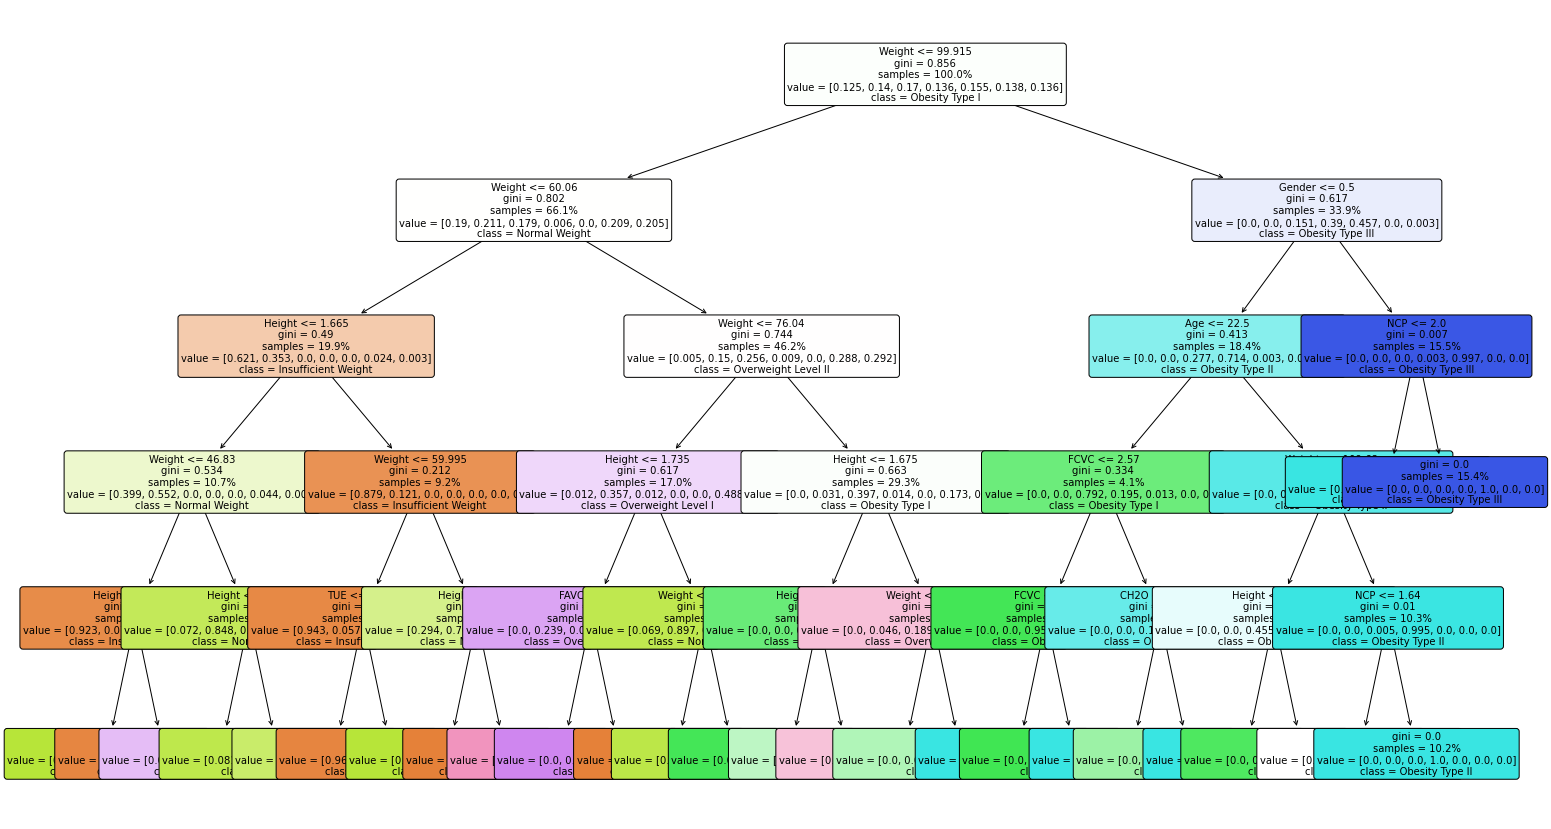

,Gender,Age,Height,Weight,Family History With Overweight,FAVC,SMOKE,SCC,FCVC,NCP,CH2O,FAF,TUE,Predictions
0,1,19,1.52,42.00,0,1,0,0,2.91,1.06,1.60,0.11,0.773,Insufficient Weight
1,0,19,1.70,79.68,1,0,0,0,2.74,2.16,1.09,0.11,0.004,Overweight Level II
2,0,18,1.84,60.00,1,1,0,0,3.00,4.00,2.00,2.00,0.000,Normal Weight
3,0,26,1.77,114.25,1,1,0,0,2.18,3.00,2.13,1.31,0.079,Obesity Type II
4,1,22,1.70,66.00,1,0,0,1,3.00,3.00,2.00,2.00,1.000,Normal Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1,18,1.59,53.00,0,0,0,0,1.00,3.00,1.00,1.00,2.000,Insufficient Weight
206,0,18,1.71,50.93,1,1,0,0,2.00,3.00,2.00,0.00,1.594,Insufficient Weight
207,1,19,1.57,41.93,0,1,0,0,2.07,1.00,1.68,0.00,1.719,Insufficient Weight
208,1,21,1.69,122.81,1,1,0,0,3.00,3.00,1.41,0.93,0.840,Obesity Type III


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

dts_unseen = raw.iloc[1900:2110].reset_index(drop=True) # Get unseen sample
dts_data = raw.iloc[0:1899].reset_index(drop=True) # Cut original dataset

# Training data
X_train = dts_data.drop('NObeyesdad', axis=1)  # Features
y_train = dts_data['NObeyesdad']              # Target

# Test data
X_test = dts_unseen.drop('NObeyesdad', axis=1)
y_test = dts_unseen['NObeyesdad']

dt_model = DecisionTreeClassifier(
    max_depth=5,          # Control tree depth to avoid overfitting
    min_samples_split=10, # Minimum samples to split a node
    random_state=42       # For reproducibility
)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

from sklearn.tree import plot_tree

plt.figure(figsize=(25, 15))
plot_tree(
    dt_model,
    feature_names=X_train.columns,
    class_names=dt_model.classes_,
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10
)
plt.show()

# Huh
dts_unseen.drop('NObeyesdad', axis=1, inplace=True)
results = model.predict(dts_unseen)

dts_unseen['Predictions'] = results
dts_unseen

In [9]:
# Original
raw.iloc[1900:2110].reset_index(drop=True) 

,Gender,Age,Height,Weight,Family History With Overweight,FAVC,SMOKE,SCC,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad
0,1,19,1.52,42.00,0,1,0,0,2.91,1.06,1.60,0.11,0.773,Insufficient Weight
1,0,19,1.70,79.68,1,0,0,0,2.74,2.16,1.09,0.11,0.004,Overweight Level II
2,0,18,1.84,60.00,1,1,0,0,3.00,4.00,2.00,2.00,0.000,Insufficient Weight
3,0,26,1.77,114.25,1,1,0,0,2.18,3.00,2.13,1.31,0.079,Obesity Type II
4,1,22,1.70,66.00,1,0,0,1,3.00,3.00,2.00,2.00,1.000,Normal Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1,18,1.59,53.00,0,0,0,0,1.00,3.00,1.00,1.00,2.000,Normal Weight
206,0,18,1.71,50.93,1,1,0,0,2.00,3.00,2.00,0.00,1.594,Insufficient Weight
207,1,19,1.57,41.93,0,1,0,0,2.07,1.00,1.68,0.00,1.719,Insufficient Weight
208,1,21,1.69,122.81,1,1,0,0,3.00,3.00,1.41,0.93,0.840,Obesity Type III
